# Bank Clients Behavior
#### to predict whether clients leave the bank or stay

#### PLAN:

##### INTRODUCTION 
##### INVESTIGETION
1. Data preprocessing
    * Checking variables
    * Class ratio
2. Logistic model (F1 and ROC AUC Metric)
    * Before balancing
        * Splitting the source data
        * Checking original data using ROC AUC score
        * Logistic Regression and Threshold
    * Balanced
        * Checking original data using ROC AUC score
        * Logistic Regression and Threshold
    * Upsampling
        * Checking original data using ROC AUC score
        * Logistic Regression and Threshold
    * Upsampling and balanced
        * Checking original data using ROC AUC score
        * Logistic Regression and Threshold
3. Decision tree and F1 test
    * Before balancing
    * Balanced
    * Upsampling
        * Moving threshold
    * After upsampling and balanced
        * Moving threshold
4. Random forest and F1 test
    * Before balancing
    * Balanced
    * Upsampling
        * Moving threshold
    * After upsampling and balanced
        * Moving threshold
5. Visualization and comparison
6. The construction of the final model

##### СONCLUSIONS

## INTRODUCTION 

The main goal of the task is to learn how to accurately predict the behavior of the bank client, in particular, to predict whether the client will leave or not. For this, data is used on existing customers who have remained or gone. Those that have gone much less then stay, so the model may work worse. To improve the quality of the model, it is necessary to balance the number of those who left to the number of those who stay.

Three methods and one combination of them will be used for balancing. One of the methods will be the introduction of the *hyperparameter* `(class_weight = 'balanced')` in the parameters of the models. **Logistic regression** will be used to create the model. Next, the *Upsampling* method and the *Threshold* offset will be applied. Then a combination of the first and second methods. To verify the quality of the model, the ROC AUC metric will be used.

Next, I will build models using the **Decision Tree** and **Random Forest** methods. The harmonized indicator F1 will be used as the main metric. I will apply all four methods of balancing the model to find the best indicator of F1.

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

## Data preprocessing

### Checking variables

In [14]:
df = pd.read_csv('/datasets/Churn.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [15]:
df['Tenure'] = df['Tenure'].fillna(value=df['Tenure'].mean())

In [16]:
df['Tenure'].describe()

count    10000.00000
mean         4.99769
std          2.76001
min          0.00000
25%          3.00000
50%          4.99769
75%          7.00000
max         10.00000
Name: Tenure, dtype: float64

'Tenure' variable has not enough values. It is necessarily to fill NA by some relevant value. 'Tenure' - means a period of maturation for a customer’s fixed deposit (years). I decided to fill NA with mean becouse this value will not affect on the final resault unlike zero. Mean and Median are not different.

In [17]:
print(df.isna().sum().sort_values(ascending=False))

Exited             0
EstimatedSalary    0
IsActiveMember     0
HasCrCard          0
NumOfProducts      0
Balance            0
Tenure             0
Age                0
Gender             0
Geography          0
CreditScore        0
Surname            0
CustomerId         0
RowNumber          0
dtype: int64


In [18]:
df = pd.get_dummies(df, drop_first=True)

In [19]:
df.head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zotova,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,619,42,2.0,0.00,1,1,1,101348.88,...,0,0,0,0,0,0,0,0,0,0
1,2,15647311,608,41,1.0,83807.86,1,0,1,112542.58,...,0,0,0,0,0,0,0,0,1,0
2,3,15619304,502,42,8.0,159660.80,3,1,0,113931.57,...,0,0,0,0,0,0,0,0,0,0
3,4,15701354,699,39,1.0,0.00,2,0,0,93826.63,...,0,0,0,0,0,0,0,0,0,0
4,5,15737888,850,43,2.0,125510.82,1,1,1,79084.10,...,0,0,0,0,0,0,0,0,1,0


**Conclusion**: The check showed the presence of missing values and variables of type object that must be converted to 1 and 0 by the OHE method. These transformations are necessary to create a classification model.

### Checking the proportionality of classes

AxesSubplot(0.125,0.125;0.775x0.755)


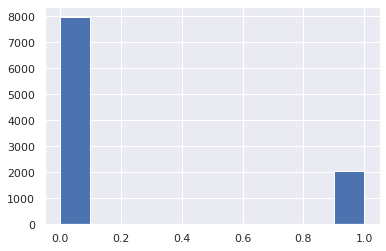

In [20]:
print(df['Exited'].hist())

**Conclusion**: Checking the balance of classes shows that there are 4 times less positive outcomes than negative ones. To build a quality model, important to bring the classes to a ratio of 50 to 50.

## Logistic Model (F1 and ROC AUC Metric)

### Before balancing

#### Spliting the source data

In [21]:
df_train, df_valid = train_test_split(df, test_size=0.25, random_state=1000001)
df_train, df_test = train_test_split(df_train, test_size=0.33, random_state=1000001)

features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']

features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited']

features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited']

In [22]:
print('df_train', df_train.shape)
print('df_valid', df_valid.shape)
print('df_test', df_test.shape)

df_train (5025, 2945)
df_valid (2500, 2945)
df_test (2475, 2945)


**Conclusion**: The data is divided into three subsamples. Training - a subsample for model training. Validation - to test training. Test - for the final testing of the model.

#### Checking original data using ROC AUC score

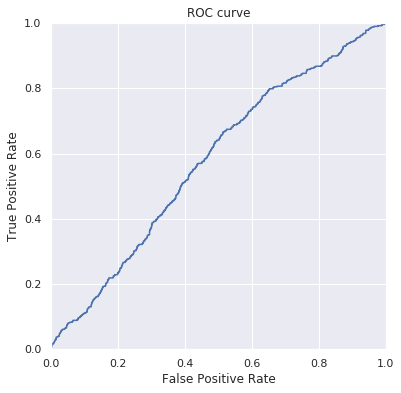

In [10]:
model = LogisticRegression(random_state=1000001)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
#name the axes "False Positive Rate" and "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#set the boundary for the axes from 0 to 1
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
#add the heading "ROC curve"
plt.title('ROC curve')
plt.show()

In [11]:
roc_auc_score(target_valid, probabilities_one_valid)

0.5767474127889427

**ROC AUC score `0.576`**

#### Logistic Regression and Threshold

In [12]:
model = LogisticRegression(random_state=1000001)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predictions_Log = probabilities_one_valid > threshold
    F1_LogR = f1_score(target_valid, predictions_Log)
    precision = precision_score(target_valid, predictions_Log)
    recall = recall_score(target_valid, predictions_Log)

    print("Threshold = {:.2f} | F1 = {:.3f}, precision = {:.3f}, recall = {:.3f}".format(
        threshold, F1_LogR, precision, recall))

Threshold = 0.00 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.05 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.10 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.15 | F1 = 0.361, precision = 0.237, recall = 0.755
Threshold = 0.20 | F1 = 0.356, precision = 0.238, recall = 0.702
Threshold = 0.25 | F1 = 0.260, precision = 0.233, recall = 0.294
Threshold = 0.30 | F1 = 0.065, precision = 0.367, recall = 0.036
Threshold = 0.35 | F1 = 0.004, precision = 1.000, recall = 0.002
Threshold = 0.40 | F1 = 0.000, precision = 0.000, recall = 0.000
Threshold = 0.45 | F1 = 0.000, precision = 0.000, recall = 0.000
Threshold = 0.50 | F1 = 0.000, precision = 0.000, recall = 0.000
Threshold = 0.55 | F1 = 0.000, precision = 0.000, recall = 0.000
Threshold = 0.60 | F1 = 0.000, precision = 0.000, recall = 0.000
Threshold = 0.65 | F1 = 0.000, precision = 0.000, recall = 0.000
Threshold = 0.70 | F1 = 0.000, precision = 0.000, recall = 0.000
Threshold = 0.75 | F1 = 0

**Conclusion**: Logistic regression shows a low F1.

### Balanced

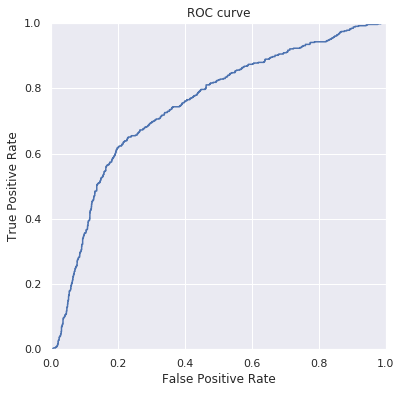

In [13]:
model = LogisticRegression(class_weight='balanced', random_state=1000001)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
#name the axes "False Positive Rate" and "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#set the boundary for the axes from 0 to 1
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
#add the heading "ROC curve"
plt.title('ROC curve')
plt.show()

In [14]:
roc_auc_score(target_valid, probabilities_one_valid)

0.7464844905888558

**ROC AUC score `0.746`**

In [15]:
model = LogisticRegression(class_weight='balanced', random_state=1000001)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predictions_Log = probabilities_one_valid > threshold
    F1_LogR = f1_score(target_valid, predictions_Log)
    precision = precision_score(target_valid, predictions_Log)
    recall = recall_score(target_valid, predictions_Log)

    print("Threshold = {:.2f} | F1 = {:.3f}, precision = {:.3f}, recall = {:.3f}".format(
        threshold, F1_LogR, precision, recall))

Threshold = 0.00 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.05 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.10 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.15 | F1 = 0.340, precision = 0.205, recall = 0.998
Threshold = 0.20 | F1 = 0.353, precision = 0.215, recall = 0.992
Threshold = 0.25 | F1 = 0.363, precision = 0.224, recall = 0.951
Threshold = 0.30 | F1 = 0.385, precision = 0.243, recall = 0.923
Threshold = 0.35 | F1 = 0.412, precision = 0.269, recall = 0.878
Threshold = 0.40 | F1 = 0.442, precision = 0.303, recall = 0.817
Threshold = 0.45 | F1 = 0.468, precision = 0.343, recall = 0.736
Threshold = 0.50 | F1 = 0.490, precision = 0.385, recall = 0.673
Threshold = 0.55 | F1 = 0.509, precision = 0.443, recall = 0.600
Threshold = 0.60 | F1 = 0.494, precision = 0.481, recall = 0.507
Threshold = 0.65 | F1 = 0.426, precision = 0.472, recall = 0.389
Threshold = 0.70 | F1 = 0.348, precision = 0.465, recall = 0.278
Threshold = 0.75 | F1 = 0

**Conclusion**: Logistic regression shows a low F1. But better than before balancing. With higher precision and recall. But still not enough for a good model.

### Upsampling

In [23]:
def upsample(df, n):
    
    # Split the training sample into negative and positive observations
    df_zeros = df[df['Exited'] == 0]
    df_ones = df[df['Exited'] == 1]
    
    # Duplicate the positive observations several times and Create a new training sample
    repeat = n
    df_upsampled = pd.concat([df_zeros] + [df_ones] * repeat)
    
    # Shuffle the data
    df_upsampled = shuffle(df_upsampled, random_state=12345)

    return df_upsampled

In [24]:
up_df_train = upsample(df_train, 4)

up_features_train = up_df_train.drop(['Exited'], axis=1)
up_target_train = up_df_train['Exited']

AxesSubplot(0.125,0.125;0.775x0.755)
Exited 0.512556658091388
Not Exited 0.48744334190861205


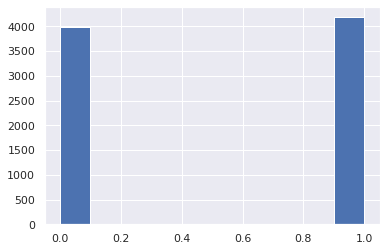

In [25]:
print(up_df_train['Exited'].hist())
print('Exited', len(up_df_train['Exited'][up_df_train['Exited'] == 1]) / len(up_df_train['Exited']))
print('Not Exited', len(up_df_train['Exited'][up_df_train['Exited'] == 0]) / len(up_df_train['Exited']))

##### Checking upsampling data using ROC AUC score

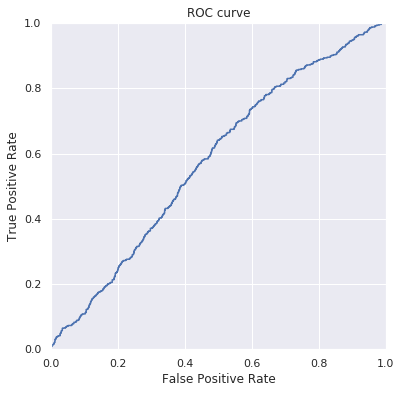

In [49]:
model = LogisticRegression(random_state=1000001)
model.fit(up_features_train, up_target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
#name the axes "False Positive Rate" and "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#set the boundary for the axes from 0 to 1
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
#add the heading "ROC curve"
plt.title('ROC curve')
plt.show()

In [50]:
roc_auc_score(target_valid, probabilities_one_valid)

0.5775807040618496

**ROC AUC score `0.577`** 

In [51]:
model = LogisticRegression(random_state=1000001)
model.fit(up_features_train, up_target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predictions_Log = probabilities_one_valid > threshold
    F1_LogR = f1_score(target_valid, predictions_Log)
    precision = precision_score(target_valid, predictions_Log)
    recall = recall_score(target_valid, predictions_Log)

    print("Threshold = {:.2f} | F1 = {:.3f}, precision = {:.3f}, recall = {:.3f}".format(
        threshold, F1_LogR, precision, recall))

Threshold = 0.00 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.05 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.10 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.15 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.20 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.25 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.30 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.35 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.40 | F1 = 0.351, precision = 0.218, recall = 0.892
Threshold = 0.45 | F1 = 0.361, precision = 0.238, recall = 0.750
Threshold = 0.50 | F1 = 0.356, precision = 0.238, recall = 0.704
Threshold = 0.55 | F1 = 0.330, precision = 0.247, recall = 0.499
Threshold = 0.60 | F1 = 0.159, precision = 0.222, recall = 0.124
Threshold = 0.65 | F1 = 0.034, precision = 0.321, recall = 0.018
Threshold = 0.70 | F1 = 0.004, precision = 1.000, recall = 0.002
Threshold = 0.75 | F1 = 0

**Conclusion**: Maximum F1 for logistic regression is `0.361` and precision is too low `0.238`. 

### Upsampling and balanced

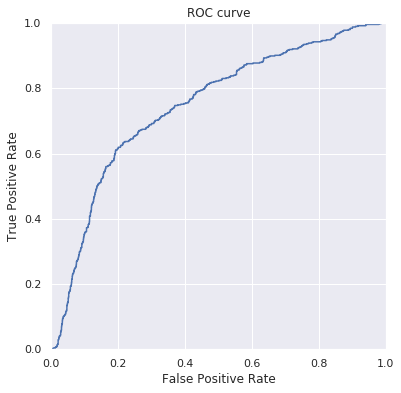

In [22]:
model = LogisticRegression(class_weight='balanced', random_state=1000001)
model.fit(up_features_train, up_target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
#name the axes "False Positive Rate" and "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#set the boundary for the axes from 0 to 1
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
#add the heading "ROC curve"
plt.title('ROC curve')
plt.show()

In [23]:
roc_auc_score(target_valid, probabilities_one_valid)

0.7462905177984881

**ROC AUC score** `0.746` 

In [32]:
model = LogisticRegression(class_weight='balanced', random_state=1000001)
model.fit(up_features_train, up_target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predictions_Log = probabilities_one_valid > threshold
    F1_LogR = f1_score(target_valid, predictions_Log)
    precision = precision_score(target_valid, predictions_Log)
    recall = recall_score(target_valid, predictions_Log)

    print("Threshold = {:.2f} | F1 = {:.3f}, precision = {:.3f}, recall = {:.3f}".format(
        threshold, F1_LogR, precision, recall))

Threshold = 0.00 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.05 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.10 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.15 | F1 = 0.339, precision = 0.204, recall = 1.000
Threshold = 0.20 | F1 = 0.349, precision = 0.212, recall = 0.996
Threshold = 0.25 | F1 = 0.363, precision = 0.223, recall = 0.968
Threshold = 0.30 | F1 = 0.381, precision = 0.239, recall = 0.935
Threshold = 0.35 | F1 = 0.406, precision = 0.263, recall = 0.890
Threshold = 0.40 | F1 = 0.436, precision = 0.296, recall = 0.822
Threshold = 0.45 | F1 = 0.465, precision = 0.339, recall = 0.740
Threshold = 0.50 | F1 = 0.491, precision = 0.386, recall = 0.675
Threshold = 0.55 | F1 = 0.504, precision = 0.442, recall = 0.586
Threshold = 0.60 | F1 = 0.485, precision = 0.481, recall = 0.489
Threshold = 0.65 | F1 = 0.407, precision = 0.467, recall = 0.361
Threshold = 0.70 | F1 = 0.336, precision = 0.468, recall = 0.262
Threshold = 0.75 | F1 = 0

**Conclusion**:

ROC AUC score:
* Original: `0.576`
* Balanced: `0.746`
* Upsampling: `0,577`
* Combination: `0.746`

F1:
* Original: Threshold = `0.10` | F1 = `0.337`
* Balanced: Threshold = `0.55` | F1 = `0.509`
* Upsampling: Threshold = `0.45` | F1 = `0.361`
* Combination: Threshold = `0.55` | F1 = `0.504`

After balancing ROC AUC increased significantly. The best result is for Balanced data. But it may be better. It is necessary to conduct testing on other models.

Need to check F1 on other models: Decision tree and Random forest

## Decision tree and F1 test

### Before balancing (DT)

In [25]:
F1_DT = pd.DataFrame(columns=['depth', 'f1_score'])

for depth in range(1, 46):
    DTClassifier = DecisionTreeClassifier(max_depth=depth, random_state=1000001)
    DTClassifier.fit(features_train, target_train)
    predictions_DT = DTClassifier.predict(features_valid)
    f1 = f1_score(target_valid, predictions_DT)
    F1_DT = F1_DT.append({'depth':depth,'f1_score':f1}, ignore_index=True)

In [26]:
F1_DT[F1_DT['f1_score'] == F1_DT['f1_score'].max()]

,depth,f1_score
4,5.0,0.557261


**Conclusion** F1 score for Decision Tree model on original data is `0.55` - worse than Logistic regression for original data

### Balanced (DT)

In [27]:
bal_F1_DT = pd.DataFrame(columns=['depth', 'f1_score'])

for depth in range(1, 46):
    DTClassifier = DecisionTreeClassifier(class_weight='balanced', max_depth=depth, random_state=1000001)
    DTClassifier.fit(features_train, target_train)
    predictions_DT = DTClassifier.predict(features_valid)
    f1 = f1_score(target_valid, predictions_DT)
    bal_F1_DT = bal_F1_DT.append({'depth':depth,'f1_score':f1}, ignore_index=True)

In [28]:
bal_F1_DT[bal_F1_DT['f1_score'] == bal_F1_DT['f1_score'].max()]

,depth,f1_score
4,5.0,0.590909


**Conclusion** F1 score for Decision Tree model on balanced data is `0.590` - a little higher

### Upsampling (DT)

In [33]:
up_F1_DT = pd.DataFrame(columns=['depth', 'f1_score'])

for depth in range(1, 46):
    DTClassifier = DecisionTreeClassifier(max_depth=depth, random_state=1000001)
    DTClassifier.fit(up_features_train, up_target_train)
    predictions_DT = DTClassifier.predict(features_valid)
    f1 = f1_score(target_valid, predictions_DT)
    up_F1_DT = up_F1_DT.append({'depth':depth,'f1_score':f1}, ignore_index=True)

In [34]:
up_F1_DT[up_F1_DT['f1_score'] == up_F1_DT['f1_score'].max()]

,depth,f1_score
4,5.0,0.59043


**Conclusion** F1 score for Decision Tree model on upsampling data is `0.590` - the same as after balansing

#### Moving Threshold

In [36]:
DTClassifier = DecisionTreeClassifier(max_depth=5, random_state=1000001)
DTClassifier.fit(up_features_train, up_target_train)

probabilities_valid = DTClassifier.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predictions_RF = probabilities_one_valid > threshold
    up_F1_RF_score = f1_score(target_valid, predictions_RF)
    precision = precision_score(target_valid, predictions_RF)
    recall = recall_score(target_valid, predictions_RF)

    print("Threshold = {:.2f} | F1 = {:.3f}, precision = {:.3f}, recall = {:.3f}".format(
        threshold, up_F1_RF_score, precision, recall))

Threshold = 0.00 | F1 = 0.336, precision = 0.202, recall = 0.994
Threshold = 0.05 | F1 = 0.336, precision = 0.202, recall = 0.994
Threshold = 0.10 | F1 = 0.336, precision = 0.202, recall = 0.994
Threshold = 0.15 | F1 = 0.426, precision = 0.274, recall = 0.963
Threshold = 0.20 | F1 = 0.426, precision = 0.274, recall = 0.963
Threshold = 0.25 | F1 = 0.458, precision = 0.303, recall = 0.935
Threshold = 0.30 | F1 = 0.463, precision = 0.308, recall = 0.933
Threshold = 0.35 | F1 = 0.508, precision = 0.363, recall = 0.844
Threshold = 0.40 | F1 = 0.513, precision = 0.375, recall = 0.811
Threshold = 0.45 | F1 = 0.590, precision = 0.501, recall = 0.718
Threshold = 0.50 | F1 = 0.590, precision = 0.501, recall = 0.718
Threshold = 0.55 | F1 = 0.601, precision = 0.534, recall = 0.688
Threshold = 0.60 | F1 = 0.601, precision = 0.534, recall = 0.688
Threshold = 0.65 | F1 = 0.594, precision = 0.584, recall = 0.606
Threshold = 0.70 | F1 = 0.594, precision = 0.584, recall = 0.606
Threshold = 0.75 | F1 = 0

**Conclusion**: The threshold shift to 0.55 or 0.60 shows increasing F1 to `0.601` from `0.590`. Better than for Logistic Regression - `0.509`

### After upsampling and balanced (DT)

In [37]:
up_bal_F1_DT = pd.DataFrame(columns=['depth', 'f1_score'])

for depth in range(1, 46):
    DTClassifier = DecisionTreeClassifier(class_weight='balanced', max_depth=depth, random_state=1000001)
    DTClassifier.fit(up_features_train, up_target_train)
    predictions_DT = DTClassifier.predict(features_valid)
    f1 = f1_score(target_valid, predictions_DT)
    up_bal_F1_DT = up_bal_F1_DT.append({'depth':depth,'f1_score':f1}, ignore_index=True)

In [38]:
up_bal_F1_DT[up_bal_F1_DT['f1_score'] == up_bal_F1_DT['f1_score'].max()]

,depth,f1_score
4,5.0,0.59043


**Conclusion** F1 score for Decision Tree model on upsampling and balanced data is `0.590` - the same as for upsampling or balanced separately.

#### Moving Threshold

In [39]:
DTClassifier = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=1000001)
DTClassifier.fit(up_features_train, up_target_train)

probabilities_valid = DTClassifier.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predictions_RF = probabilities_one_valid > threshold
    up_F1_RF_score = f1_score(target_valid, predictions_RF)
    precision = precision_score(target_valid, predictions_RF)
    recall = recall_score(target_valid, predictions_RF)

    print("Threshold = {:.2f} | F1 = {:.3f}, precision = {:.3f}, recall = {:.3f}".format(
        threshold, up_F1_RF_score, precision, recall))

Threshold = 0.00 | F1 = 0.336, precision = 0.202, recall = 0.994
Threshold = 0.05 | F1 = 0.336, precision = 0.202, recall = 0.994
Threshold = 0.10 | F1 = 0.409, precision = 0.259, recall = 0.968
Threshold = 0.15 | F1 = 0.426, precision = 0.274, recall = 0.963
Threshold = 0.20 | F1 = 0.426, precision = 0.274, recall = 0.963
Threshold = 0.25 | F1 = 0.458, precision = 0.303, recall = 0.935
Threshold = 0.30 | F1 = 0.508, precision = 0.363, recall = 0.844
Threshold = 0.35 | F1 = 0.508, precision = 0.363, recall = 0.844
Threshold = 0.40 | F1 = 0.513, precision = 0.375, recall = 0.811
Threshold = 0.45 | F1 = 0.590, precision = 0.501, recall = 0.718
Threshold = 0.50 | F1 = 0.590, precision = 0.501, recall = 0.718
Threshold = 0.55 | F1 = 0.601, precision = 0.534, recall = 0.688
Threshold = 0.60 | F1 = 0.601, precision = 0.534, recall = 0.688
Threshold = 0.65 | F1 = 0.594, precision = 0.584, recall = 0.606
Threshold = 0.70 | F1 = 0.555, precision = 0.714, recall = 0.454
Threshold = 0.75 | F1 = 0

**Conclusion**: The same as for shifting Threshold for upsampling. The threshold shift to 0.55 or 0.60 shows increasing F1 to `0.601` from `0.590`. Better than for Logistic Regression - `0.509`

F1 score for Decision tree:
* Original: `0.557`
* Balanced: `0.590`
* Upsampling: `0.590`
* Upsampling (Threshold 0.6): `0.601`
* Combination: `0.590`
* Combination (Threshold 0.6): `0.601`

Balancing, Upsampling or Combination of them doesn't show significant increase of F1. Shifting Threshold to `0.601` shows slight increase for Upsampling and Combination. Better than for Logistic Regression - `0.509`

## Random Forest and F1 test

### Before upsampling

In [58]:
F1_RF = pd.DataFrame(columns=['max_depth', 'estim', 'f1_score'])
    
for max_depth in range(1, 46):
    for estim in range(10, 60, 20):
        RFClassifier = RandomForestClassifier(n_estimators=estim, max_depth=max_depth, random_state=1000001)
        RFClassifier.fit(features_train, target_train)
        predictions_RF = RFClassifier.predict(features_valid)
        f1 = f1_score(target_valid, predictions_RF)
        F1_RF = F1_RF.append({'max_depth':max_depth, 'estim':estim, 'f1_score':f1}, ignore_index=True)

In [39]:
F1_RF[F1_RF['f1_score'] == F1_RF['f1_score'].max()]

,max_depth,estim,f1_score
132,45.0,10.0,0.35969


**Conclusion** F1 score for Random Forest model on original data is `0.359`

### Balanced

In [40]:
bal_F1_RF = pd.DataFrame(columns=['max_depth', 'estim', 'f1_score'])
    
for max_depth in range(1, 46):
    for estim in range(10, 60, 20):
        RFClassifier = RandomForestClassifier(class_weight='balanced', n_estimators=estim, max_depth=max_depth, random_state=1000001)
        RFClassifier.fit(features_train, target_train)
        predictions_RF = RFClassifier.predict(features_valid)
        f1 = f1_score(target_valid, predictions_RF)
        bal_F1_RF = bal_F1_RF.append({'max_depth':max_depth, 'estim':estim, 'f1_score':f1}, ignore_index=True)

In [41]:
bal_F1_RF[bal_F1_RF['f1_score'] == bal_F1_RF['f1_score'].max()]

,max_depth,estim,f1_score
92,31.0,50.0,0.602985


**Conclusion** F1 score for Random Forest model on balanced data is `0.603`

### Upsampling

In [40]:
up_F1_RF = pd.DataFrame(columns=['max_depth', 'estim', 'f1_score'])
    
for max_depth in range(1, 46):
    for estim in range(10, 60, 20):
        RFClassifier = RandomForestClassifier(n_estimators=estim, max_depth=max_depth, random_state=1000001)
        RFClassifier.fit(up_features_train, up_target_train)
        predictions_RF = RFClassifier.predict(features_valid)
        f1 = f1_score(target_valid, predictions_RF)
        up_F1_RF = up_F1_RF.append({'max_depth':max_depth, 'estim':estim, 'f1_score':f1}, ignore_index=True)

In [41]:
up_F1_RF[up_F1_RF['f1_score'] == up_F1_RF['f1_score'].max()]

,max_depth,estim,f1_score
130,44.0,30.0,0.607938


**Conclusion** F1 score for Random Forest model on upsampling data is `0.608`

#### Moving Threshold

In [42]:
RFClassifier = RandomForestClassifier(n_estimators=30, max_depth=44, random_state=1000001)
RFClassifier.fit(up_features_train, up_target_train)

probabilities_valid = RFClassifier.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predictions_RF = probabilities_one_valid > threshold
    F1_RF_score = f1_score(target_valid, predictions_RF)
    precision = precision_score(target_valid, predictions_RF)
    recall = recall_score(target_valid, predictions_RF)

    print("Threshold = {:.2f} | F1 = {:.3f}, precision = {:.3f}, recall = {:.3f}".format(
        threshold, F1_RF_score, precision, recall))

Threshold = 0.00 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.05 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.10 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.15 | F1 = 0.340, precision = 0.205, recall = 1.000
Threshold = 0.20 | F1 = 0.364, precision = 0.223, recall = 0.992
Threshold = 0.25 | F1 = 0.400, precision = 0.252, recall = 0.963
Threshold = 0.30 | F1 = 0.446, precision = 0.294, recall = 0.925
Threshold = 0.35 | F1 = 0.509, precision = 0.359, recall = 0.878
Threshold = 0.40 | F1 = 0.554, precision = 0.429, recall = 0.781
Threshold = 0.45 | F1 = 0.586, precision = 0.504, recall = 0.700
Threshold = 0.50 | F1 = 0.608, precision = 0.597, recall = 0.619
Threshold = 0.55 | F1 = 0.593, precision = 0.668, recall = 0.533
Threshold = 0.60 | F1 = 0.538, precision = 0.704, recall = 0.436
Threshold = 0.65 | F1 = 0.427, precision = 0.720, recall = 0.304
Threshold = 0.70 | F1 = 0.337, precision = 0.836, recall = 0.211
Threshold = 0.75 | F1 = 0

**Conclusion**: The threshold shift did not show the possibility of increasing F1

### After upsampling and balanced

In [43]:
up_bal_F1_RF = pd.DataFrame(columns=['max_depth', 'estim', 'f1_score'])
    
for max_depth in range(1, 46):
    for estim in range(10, 60, 20):
        RFClassifier = RandomForestClassifier(class_weight='balanced', n_estimators=estim, max_depth=max_depth, random_state=1000001)
        RFClassifier.fit(up_features_train, up_target_train)
        predictions_RF = RFClassifier.predict(features_valid)
        f1 = f1_score(target_valid, predictions_RF)
        up_bal_F1_RF = up_bal_F1_RF.append({'max_depth':max_depth, 'estim':estim, 'f1_score':f1}, ignore_index=True)

In [44]:
up_bal_F1_RF[up_bal_F1_RF['f1_score'] == up_bal_F1_RF['f1_score'].max()]

,max_depth,estim,f1_score
134,45.0,50.0,0.603951


**Conclusion** F1 score for Random Forest model on upsampling and balanced data is `0.604`

#### Moving Threshold

In [45]:
RFClassifier = RandomForestClassifier(class_weight='balanced', n_estimators=50, max_depth=45, random_state=1000001)
RFClassifier.fit(up_features_train, up_target_train)

probabilities_valid = RFClassifier.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predictions_RF = probabilities_one_valid > threshold
    F1_RF_score = f1_score(target_valid, predictions_RF)
    precision = precision_score(target_valid, predictions_RF)
    recall = recall_score(target_valid, predictions_RF)

    print("Threshold = {:.2f} | F1 = {:.3f}, precision = {:.3f}, recall = {:.3f}".format(
        threshold, F1_RF_score, precision, recall))

Threshold = 0.00 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.05 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.10 | F1 = 0.337, precision = 0.203, recall = 1.000
Threshold = 0.15 | F1 = 0.343, precision = 0.207, recall = 1.000
Threshold = 0.20 | F1 = 0.369, precision = 0.227, recall = 0.992
Threshold = 0.25 | F1 = 0.405, precision = 0.255, recall = 0.974
Threshold = 0.30 | F1 = 0.451, precision = 0.298, recall = 0.923
Threshold = 0.35 | F1 = 0.504, precision = 0.357, recall = 0.858
Threshold = 0.40 | F1 = 0.562, precision = 0.432, recall = 0.805
Threshold = 0.45 | F1 = 0.592, precision = 0.504, recall = 0.718
Threshold = 0.50 | F1 = 0.604, precision = 0.577, recall = 0.633
Threshold = 0.55 | F1 = 0.594, precision = 0.667, recall = 0.535
Threshold = 0.60 | F1 = 0.527, precision = 0.724, recall = 0.414
Threshold = 0.65 | F1 = 0.421, precision = 0.781, recall = 0.288
Threshold = 0.70 | F1 = 0.273, precision = 0.872, recall = 0.162
Threshold = 0.75 | F1 = 0

**Conclusion**: The threshold shift did not show the possibility of increasing F1.

F1 score for Decision tree:
* Original: `0.359`
* Balanced: `0.603`
* Upsampling: `0.603`
* Combination: `0.604`

Also for Random Forest as for Decision Tree Balancing, Upsampling or Combination of them doesn't show significant increase of F1. The threshold shift did not show the possibility of increasing F1.

Random Forest model on the combination of the balanced and upsampling data showed the best F1 - `0.604`

## Visualization of the F1 results

### Before balanced

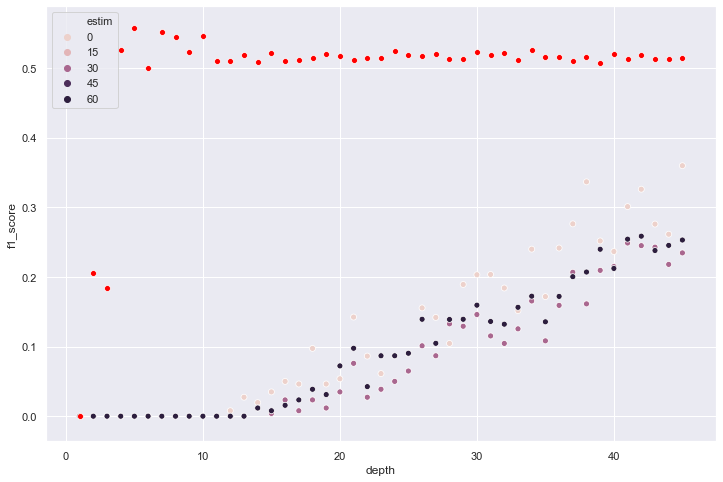

In [59]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="max_depth", y="f1_score", hue="estim",
                     data=F1_RF)
sns.scatterplot(x="depth", y="f1_score",
                     data=F1_DT, ax=ax, color='red')

### Balansed

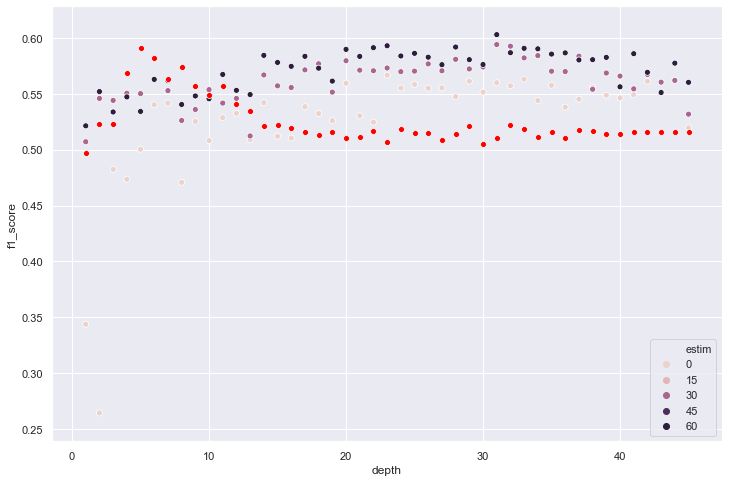

In [54]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="max_depth", y="f1_score", hue="estim",
                     data=bal_F1_RF)
sns.scatterplot(x="depth", y="f1_score",
                     data=bal_F1_DT, ax=ax, color='red')

### Upsampling

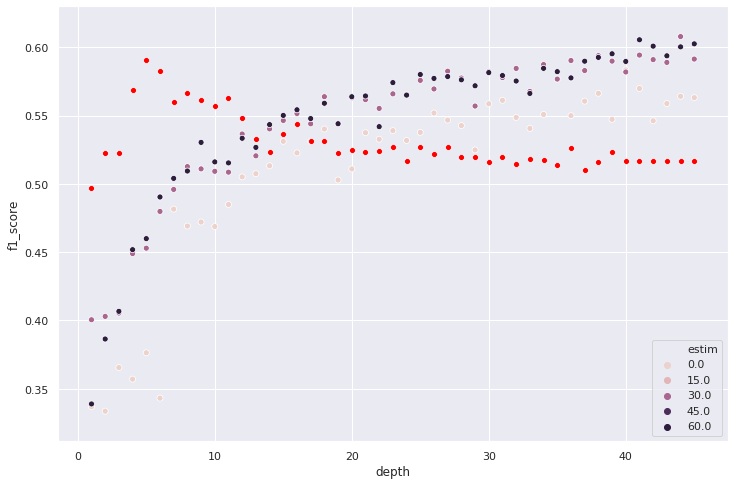

In [46]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="max_depth", y="f1_score", hue="estim",
                     data=up_F1_RF)
sns.scatterplot(x="depth", y="f1_score",
                     data=up_F1_DT, ax=ax, color='red')

### Upsampling and Balansed

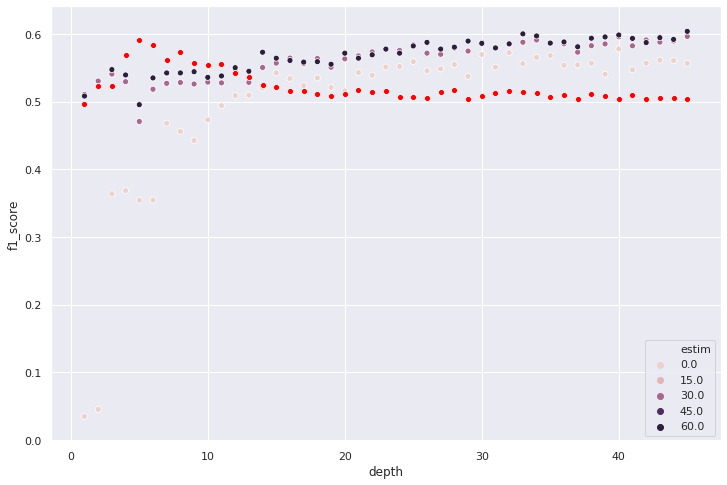

In [47]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="max_depth", y="f1_score", hue="estim",
                     data=up_bal_F1_RF)
sns.scatterplot(x="depth", y="f1_score",
                     data=up_bal_F1_DT, ax=ax, color='red')

## Building of the final model

### Random Forest with resampling and balanced parameter

In [26]:
RFClassifier = RandomForestClassifier(class_weight='balanced', n_estimators=50, max_depth=45, random_state=1000001)
RFClassifier.fit(up_features_train, up_target_train)
predictions_RF = RFClassifier.predict(features_test)
f1 = f1_score(target_test, predictions_RF)
print('f1 score:', f1)

f1 score: 0.5988258317025441


## GENERAL CONCLUSION

As can been see, balancing has a significant affects the quality of the model. The decision tree turned out to be the best method on this dataset. But not by a large margin. Upsampling and Сombination show an equally high F1 for Decision Tree and Random Forest. But for Logistic Regression Upsampling shows lower results than Balanced method. Changing the cut-off line show a vary small affect.

Because of tests, it was revealed that the best model is a Random Forest with a combination of the balanced methods. With a maximum F1 of 0.604 - the number of correct classifications of the total number, with a maximum depth of 45, and 50 of estimators.

**Final F1 for the test set is 0.599**